# Overview

## Team Members

Oren Carmeli, Sam Stephens, Stephen Bridwell, Jon Hand.

## Dataset

The dataset includes recorded attributes of four wilderness areas located in the Roosevelt National Forest of northern Colorado. Each observation (i.e record) is a 30m x 30x patch of land. 


## Inference Problem
Predict the forest cover type (the predominant kind of tree cover) from strictly cartographic variables (as opposed to remotely sensed data). 

Cartographic variables (X) include features such as elevation, soil type, and slope of land. The forest cover types (Y) include;
1. Spruce/Fir
2. Lodgepole Pine
3. Ponderosa Pine
4. Cottonwood/Willow
5. Aspen
6. Douglas-fir
7. Krummholz

Understanding forest composition is a valuable aspect of managing the health and vitality of our wilderness areas. Classifying cover type can help further research regarding forest fire susceptibility, the spread of the Mountain Pine Beetle infestion, and de-reforestation concerns [[link]](http://cs229.stanford.edu/proj2014/Kevin%20Crain,%20Graham%20Davis,%20Classifying%20Forest%20Cover%20Type%20using%20Cartographic%20Features.pdf).

# Preprocessing

In [2]:
import pandas as pd 
import numpy as np
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import  GradientBoostingClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC 
from sklearn.neural_network import MLPClassifier

from sklearn import tree

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import json
import pickle
from IPython.display import Image

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

k_folds = 5
%matplotlib inline

In [3]:
np.random.seed(0)

# ^^^^^^^^^^^^^^^^^^^^^^^^^
# load data

train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

# ^^^^^^^^^^^^^^^^^^^^^^^^^
# set up modeling datasets

# X = all but last column 
X_train = np.array(train.iloc[:,:-1])
X_test = np.array(test)

# Y = last column only
Y_train = np.array(train.iloc[:,-1].tolist())

# build dev set based on random subset (10% of train data)
shuffle = np.random.permutation(np.arange(X_train.shape[0]))
X_train, Y_train = X_train[shuffle], Y_train[shuffle]

dev_size = round(X_train.shape[0] * 0.1)
dev_data, dev_labels = X_train[:dev_size], Y_train[:dev_size]
train_data, train_labels = X_train[dev_size:], Y_train[dev_size:]
test_data = X_test

print('Train Data shape: ', train_data.shape)
print('Train Labels shape: ', train_labels.shape)
print()
print('Dev Data shape: ', dev_data.shape)
print('Dev Labels shape: ', dev_labels.shape)
print()
print('Test Data shape: ', test_data.shape)
print()

# check dev split works
print(f'Dev split check status: {dev_data.shape[0] + train_data.shape[0] == X_train.shape[0]}')

Train Data shape:  (13608, 55)
Train Labels shape:  (13608,)

Dev Data shape:  (1512, 55)
Dev Labels shape:  (1512,)

Test Data shape:  (565892, 55)

Dev split check status: True


In [4]:
# append cover type labels
label_categories = ['Spruce/Fir', 
                    'Lodgepole Pine', 
                    'Ponderosa Pine', 
                    'Cottonwood/Willow', 
                    'Aspen',
                    'Douglas-fir',
                    'Krummholz']
label_categories = pd.DataFrame(data = zip(label_categories,list(range(1,8,1))), columns = ['Cover_Type_Name','Cover_Type'])
train_df = train.merge(label_categories, left_on='Cover_Type', right_on='Cover_Type')

# filter to be same subset as in train_data created above
train_df = train_df.iloc[shuffle,:].iloc[dev_size:, :]
train_df

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type,Cover_Type_Name
7809,9940,3290,334,22,277,64,1905,163,204,177,467,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,7,Krummholz
5193,8295,3218,111,19,67,-1,3291,249,215,86,845,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,Spruce/Fir
10663,14280,2759,307,5,474,69,1468,207,237,169,1855,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,Ponderosa Pine
6086,11860,3168,304,14,201,25,4670,180,232,192,1154,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Spruce/Fir
3064,3062,3025,341,17,361,20,295,181,212,168,1273,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,Lodgepole Pine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,3089,2341,61,25,379,51,700,231,181,68,335,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,Cottonwood/Willow
3264,7097,2738,106,12,324,109,864,241,225,112,997,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2,Lodgepole Pine
9845,8258,2593,202,23,277,54,1441,202,253,175,2017,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,Ponderosa Pine
10799,15120,2475,197,34,319,78,270,189,244,164,914,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,Ponderosa Pine


# EDA

In [5]:
train_df.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type,Cover_Type_Name
7809,9940,3290,334,22,277,64,1905,163,204,177,467,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,7,Krummholz
5193,8295,3218,111,19,67,-1,3291,249,215,86,845,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,Spruce/Fir
10663,14280,2759,307,5,474,69,1468,207,237,169,1855,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,Ponderosa Pine
6086,11860,3168,304,14,201,25,4670,180,232,192,1154,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,Spruce/Fir
3064,3062,3025,341,17,361,20,295,181,212,168,1273,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,Lodgepole Pine


In [6]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,13608.0,7561.833407,4361.711870,1.0,3783.75,7581.5,11333.25,15120.0
Elevation,13608.0,2750.784465,417.651721,1863.0,2376.00,2752.0,3107.00,3849.0
Aspect,13608.0,156.310259,109.998264,0.0,65.00,125.0,260.00,360.0
Slope,13608.0,16.484641,8.436757,0.0,10.00,15.0,22.00,52.0
Horizontal_Distance_To_Hydrology,13608.0,228.376911,210.430406,0.0,67.00,180.0,330.00,1343.0
Vertical_Distance_To_Hydrology,13608.0,51.300999,61.406202,-146.0,5.00,33.0,79.00,554.0
Horizontal_Distance_To_Roadways,13608.0,1717.970165,1324.621325,0.0,764.00,1318.0,2280.00,6890.0
Hillshade_9am,13608.0,212.755879,30.542749,0.0,196.00,220.0,235.00,254.0
Hillshade_Noon,13608.0,218.993974,22.737076,99.0,207.00,223.0,235.00,254.0
Hillshade_3pm,13608.0,135.074809,45.859581,0.0,106.00,138.0,167.00,248.0


In [15]:
# distribution of train data labels
train_df['Cover_Type_Name'].value_counts()

Krummholz            1954
Lodgepole Pine       1953
Spruce/Fir           1950
Ponderosa Pine       1949
Cottonwood/Willow    1943
Aspen                1936
Douglas-fir          1923
Name: Cover_Type_Name, dtype: int64

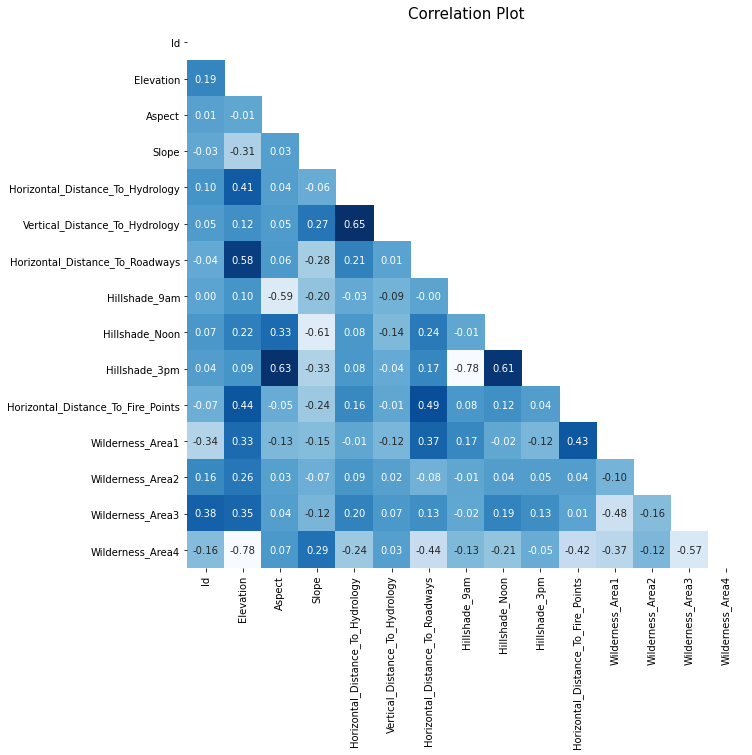

In [20]:
# correlation plot
corr = train_df.iloc[:, 0:15].corr()

# make mask (only plot lower left triangle)
mask = np.ones_like(corr,dtype = np.bool)
mask = np.triu(mask)

# plot the heatmap
fig, ax = plt.subplots(figsize=(10,10))         
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        mask = mask,
        annot=True, 
        fmt='.2f',
        cmap="Blues",
        cbar=False)

plt.title('Correlation Plot',size=15)
plt.show()
pass

In [22]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr

print("Top Absolute Correlations")
print(get_top_abs_correlations(train_df.iloc[:,:-2])[0:7])

Top Absolute Correlations
Elevation                         Wilderness_Area4                  0.784044
Hillshade_9am                     Hillshade_3pm                     0.780632
Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology    0.651220
Aspect                            Hillshade_3pm                     0.634638
Hillshade_Noon                    Hillshade_3pm                     0.614209
Slope                             Hillshade_Noon                    0.611931
Aspect                            Hillshade_9am                     0.593412
dtype: float64


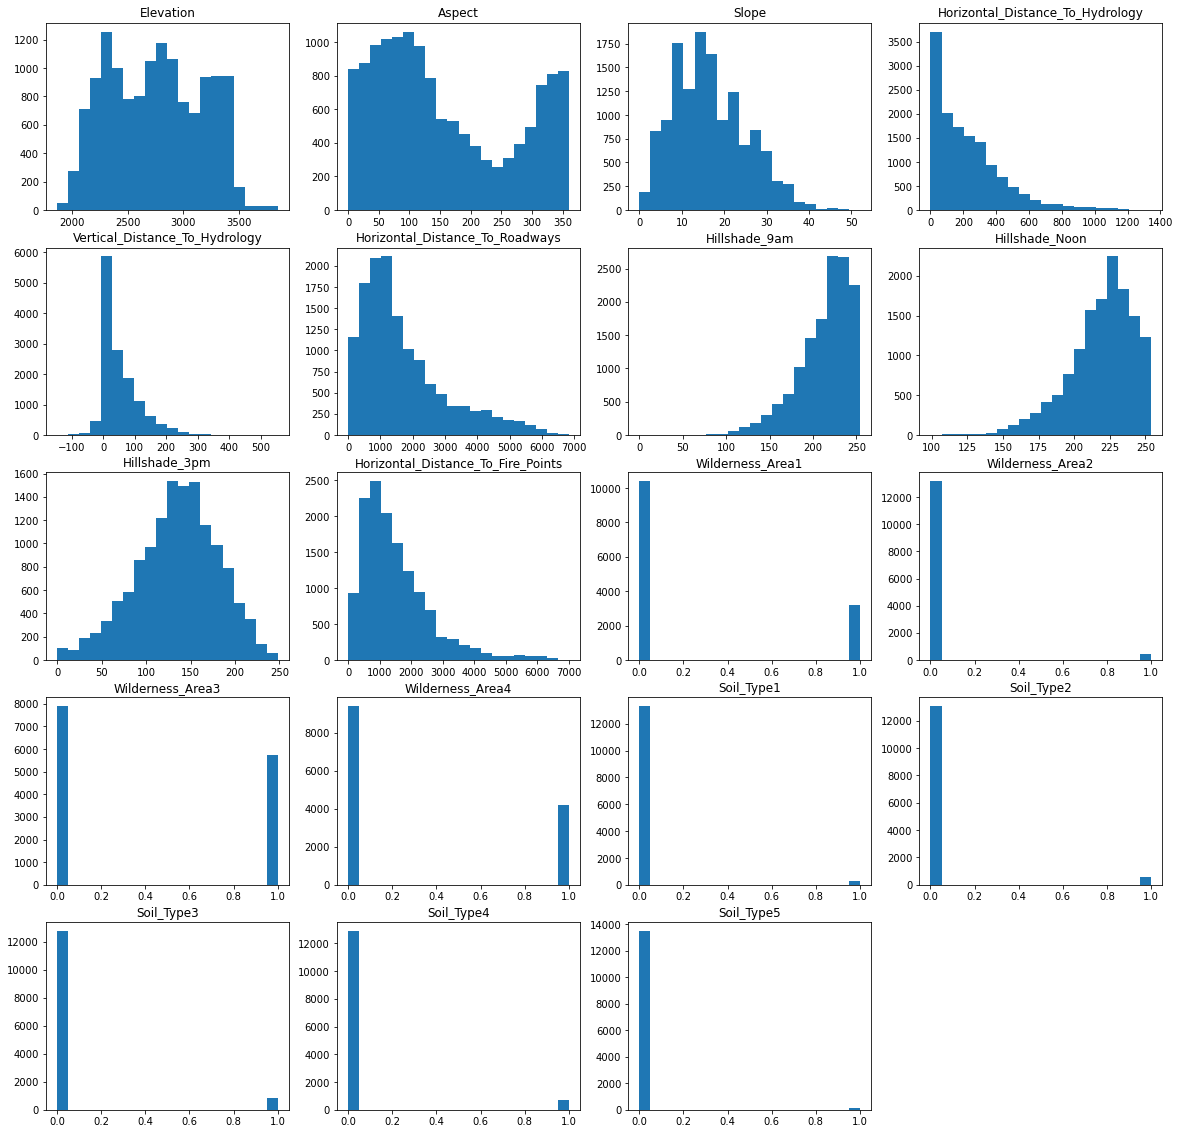

In [7]:
# Create a new figure and set the figsize argument so we get square-ish plots of the 4 features.
plt.figure(figsize=(20, 20))

feature_cols = train_df.columns.tolist()

# Iterate over the features, creating a subplot with a histogram for each one.
for feature in range(1, 20): #train_data.shape[1]
    plt.subplot(5, 4, feature)
    plt.hist(train_data[:,feature], 20)
    plt.title(feature_cols[feature])

In [96]:
wild_cols = [col for col in train_df.columns if 'Wilderness' in col]
wild_cols += ['Cover_Type']

wilderness_cover_type = train_df[wild_cols].groupby(['Cover_Type']).sum()
wilderness_cover_type = wilderness_cover_type.reset_index()
wilderness_cover_type = pd.melt(wilderness_cover_type, id_vars=['Cover_Type'])

wilderness_cover_type.head()

,Cover_Type,variable,value
0,1,Wilderness_Area1,958
1,2,Wilderness_Area1,1026
2,3,Wilderness_Area1,0
3,4,Wilderness_Area1,0
4,5,Wilderness_Area1,765


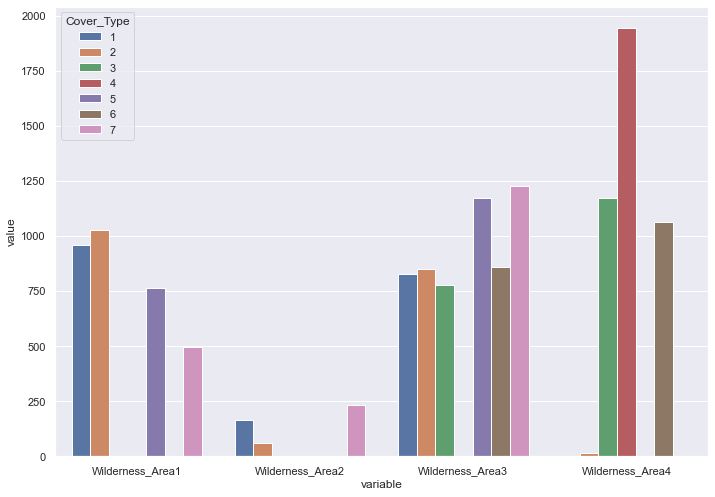

In [79]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
# Plot for Category1    
sns.barplot(x='variable', y='value', hue="Cover_Type", data=wilderness_cover_type)
plt.show()


In [93]:
soil_cols = [col for col in train_df.columns if 'Soil' in col]
soil_cols += ['Cover_Type']

soil_cover_type = train_df[soil_cols].groupby(['Cover_Type']).sum()
soil_cover_type = soil_cover_type.reset_index()

soil_cover_type = pd.melt(soil_cover_type, id_vars=['Cover_Type'])
soil_cover_type['variable'] = soil_cover_type['variable'].str.extract('(\d+)').astype(int)

soil_cover_type_1 = soil_cover_type[soil_cover_type['variable'] <= 20]
soil_cover_type_2 = soil_cover_type[soil_cover_type['variable'] > 20]
soil_cover_type

,Cover_Type,variable,value
0,1,1,0
1,2,1,0
2,3,1,113
3,4,1,126
4,5,1,0
...,...,...,...
275,3,40,0
276,4,40,0
277,5,40,0
278,6,40,0


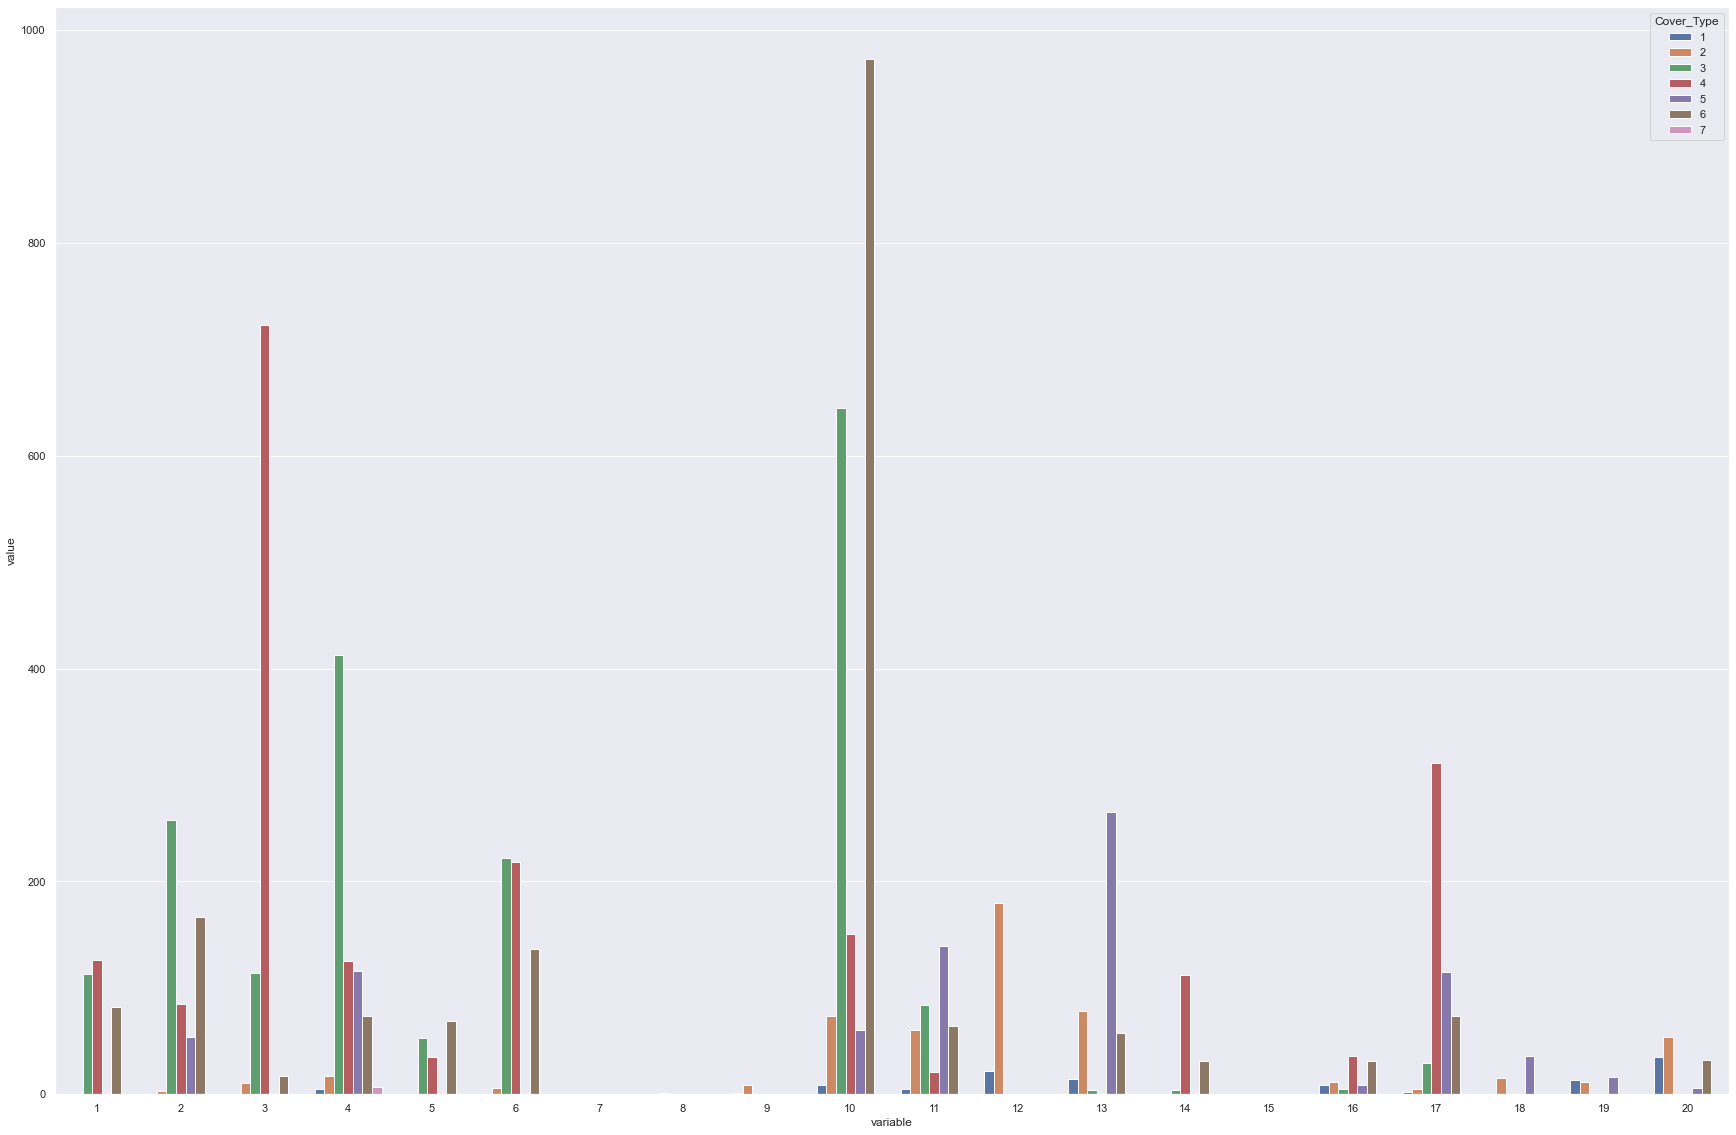

In [94]:
sns.set(rc={'figure.figsize':(30,20)})
# Plot for Category1    
sns.barplot(x='variable', y='value', hue="Cover_Type", data=soil_cover_type_1)
plt.show()


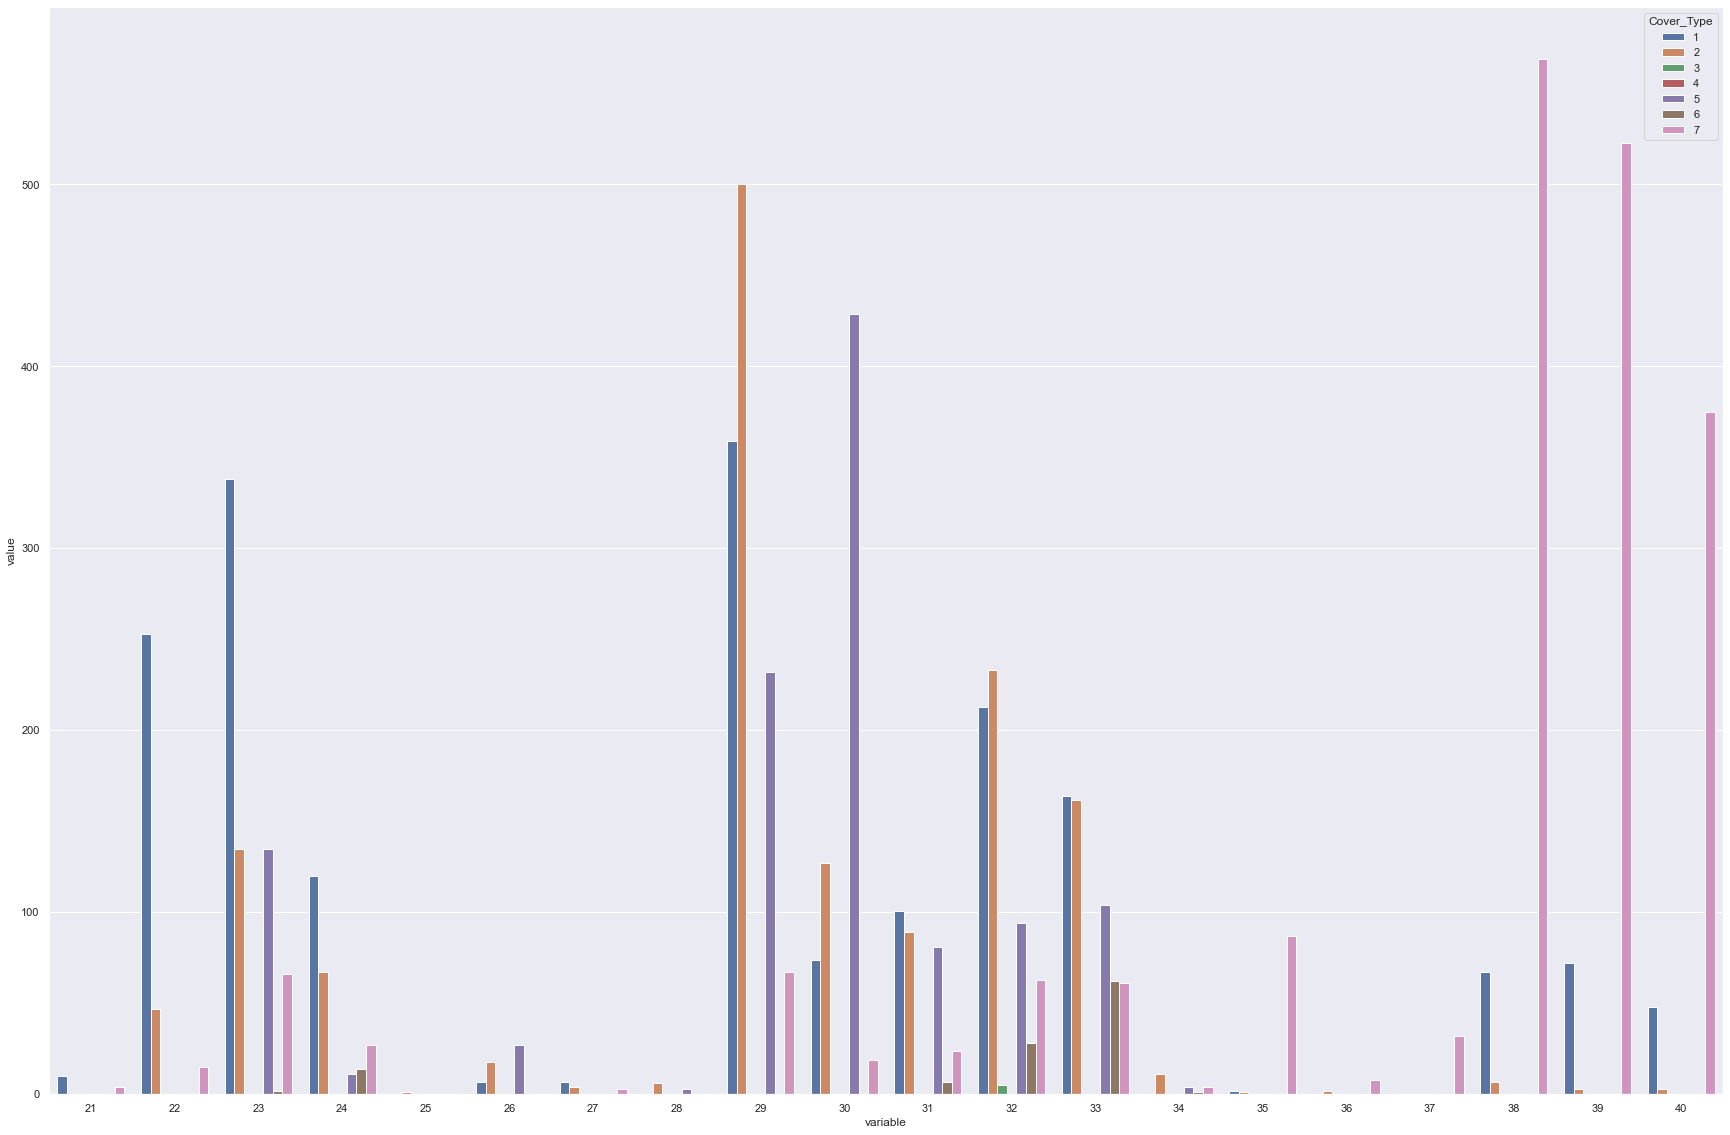

In [95]:
sns.set(rc={'figure.figsize':(30,20)})
# Plot for Category1    
sns.barplot(x='variable', y='value', hue="Cover_Type", data=soil_cover_type_2)
plt.show()


In [8]:
train_df.astype(bool).sum(axis=0).reset_index(name='Non-Zeros')

,index,Non-Zeros
0,Id,13608
1,Elevation,13608
2,Aspect,13511
3,Slope,13603
4,Horizontal_Distance_To_Hydrology,12198
5,Vertical_Distance_To_Hydrology,11923
6,Horizontal_Distance_To_Roadways,13605
7,Hillshade_9am,13607
8,Hillshade_Noon,13608
9,Hillshade_3pm,13529


# Model Testing

We tested a total of 4 different classifiers. For each we fit the model on the `train_data` and generalized on the `dev_data`. The `test_data` from the kaggle website doesn't contain any class labels.
- K-nn: accuracy of ~**85.6%**
- Bernoulli Naive Bayes: accuracy of ~**60.5%**
- Gaussian Naive Bayes: accuracy of ~**64.2%**
- Logistic Regression: accuracy of ~**63%-65%**

## KNN

KNN accuracy with no filtering: 0.8564814814814815
i = 1
KNN accuracy with no filtering: 0.5346062052505967
i = 2
KNN accuracy with no filtering: 0.5274463007159904
i = 3
KNN accuracy with no filtering: 0.5155131264916468
i = 4
KNN accuracy with no filtering: 0.5274463007159904
i = 5
KNN accuracy with no filtering: 0.522673031026253
i = 6
KNN accuracy with no filtering: 0.5202863961813843


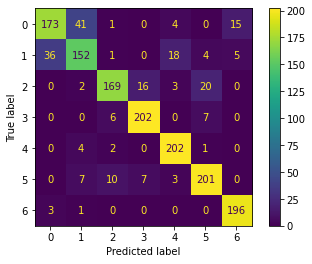

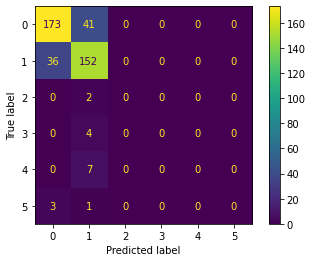

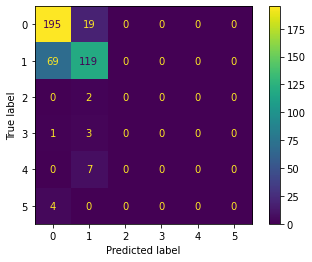

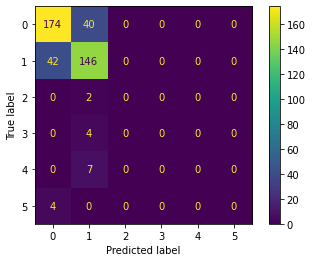

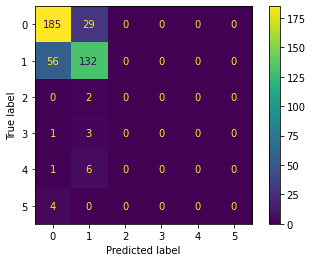

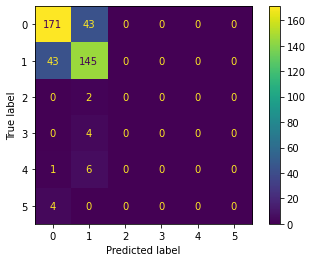

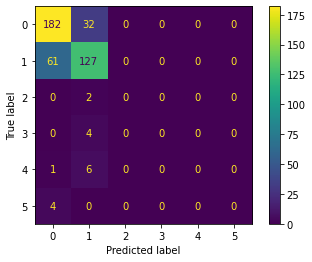

In [41]:
def knn():
    
    knn = KNeighborsClassifier(n_neighbors=1)

    knn.fit(train_data, train_labels) #train on processed train data

    pred_knn  = knn.predict(dev_data) #predict on dev data

    accuracy_count_knn = 0

    for j in range(pred_knn.shape[0]):
        if pred_knn[j] == dev_labels[j]:
            accuracy_count_knn += 1
        else:
            continue

    print("KNN accuracy with no filtering: " + str (accuracy_count_knn/pred_knn.shape[0]))

    cm = confusion_matrix(dev_labels, pred_knn)

    ConfusionMatrixDisplay(cm).plot()
    
    ########## just type 1 and 2 ##########
    
    for i in range(1,7):
        print(f'i = {i}')
        knn_1_2 = KNeighborsClassifier(n_neighbors=i)

        train_data_1_2 = train_data[(train_labels == 1) | (train_labels == 2)]
        train_labels_1_2 = train_labels[(train_labels == 1) | (train_labels == 2)]

        dev_data_1_2 = dev_data[(dev_labels == 1) | (dev_labels == 2)]
        dev_labels_1_2 = dev_labels[(dev_labels == 1) | (dev_labels == 2)]

        pred_knn_1_2_data = dev_data[(pred_knn == 1) | (pred_knn == 2)]
        pred_knn_1_2_actual_labels = dev_labels[(pred_knn == 1) | (pred_knn == 2)]

        knn_1_2.fit(train_data_1_2, train_labels_1_2)

        pred_knn_1_2  = knn_1_2.predict(pred_knn_1_2_data) #predict on dev data

        accuracy_count_knn_1_2 = 0

        for j in range(pred_knn_1_2.shape[0]):
            if pred_knn_1_2[j] == pred_knn_1_2_actual_labels[j]:
                accuracy_count_knn_1_2 += 1
            else:
                continue

        print("KNN accuracy with no filtering: " + str (accuracy_count_knn_1_2/pred_knn_1_2.shape[0]))

        cm_1_2 = confusion_matrix(pred_knn_1_2_actual_labels, pred_knn_1_2)

        ConfusionMatrixDisplay(cm_1_2).plot()
    
      
knn()

## Bernoulli NB w/ Grid Search

In [10]:
def bernoulli_nb(alphas):

    # BernoulliNB training
    model_nb = BernoulliNB()
    model_nb.fit(train_data, train_labels)

    # use cros validation = 5 to validate the alphas
    model_cv = GridSearchCV(estimator=model_nb, param_grid=alphas, cv=5, scoring='accuracy')
    model_cv.fit(train_data, train_labels)

    # create the data frame
    params = [param['alpha'] for param in model_cv.cv_results_["params"]]
    mean_test_score = model_cv.cv_results_["mean_test_score"]
    std_test_score = model_cv.cv_results_["std_test_score"]
    df = pd.DataFrame(list(zip(params, mean_test_score,std_test_score)),
                   columns =['alpha', 'mean_test_score',"std_test_score"])
    print(df)
    
alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
bernoulli_nb(alphas)

          alpha  mean_test_score  std_test_score
0  1.000000e-10         0.595607        0.012450
1  1.000000e-04         0.595607        0.012450
2  1.000000e-03         0.595607        0.012450
3  1.000000e-02         0.595607        0.012450
4  1.000000e-01         0.595680        0.012555
5  5.000000e-01         0.595754        0.012449
6  1.000000e+00         0.595754        0.012655
7  2.000000e+00         0.595533        0.012278
8  1.000000e+01         0.592226        0.012280


## Gaussian & Bernoulli Naive Bayes

In [11]:
def gaussian_nb():


    ####Train on GaussianNB with no var_smoothing####
    model_gnb = GaussianNB()
    model_gnb.fit(train_data,train_labels)

    sigmas = model_gnb.sigma_
    thetas = model_gnb.theta_

    ## predict on dev data

    pred_gnb = model_gnb.predict(dev_data)
    accuracy_count_gnb = 0


    ###generate accuracy
    for j in range(dev_labels.shape[0]):
        if pred_gnb[j] == dev_labels[j]:
            accuracy_count_gnb += 1
        else:
            continue

    print("GaussianNB accuracy w/ no modification: " + str(accuracy_count_gnb/pred_gnb.shape[0]))

    ###Train on gaussianNB with var_smoothing = .1###

    model_gnb_s = GaussianNB(var_smoothing=.1)
    model_gnb_s.fit(train_data,train_labels)

    sigmas2 = model_gnb_s.sigma_
    thetas2 = model_gnb_s.theta_


    ## predict on dev data

    pred_gnb_s = model_gnb_s.predict(dev_data)
    accuracy_count_gnb_s = 0


    ###generate accuracy
    for j in range(dev_labels.shape[0]):
        if pred_gnb_s[j] == dev_labels[j]:
            accuracy_count_gnb_s += 1
        else:
            continue

    print("GaussianNB accuracy w/ var smoothing @ .1: " + str(accuracy_count_gnb_s/pred_gnb_s.shape[0]))

    #train on bernoulliNB

    model_gnb_s2 = BernoulliNB()
    model_gnb_s2.fit(train_data,train_labels)

    pred_gnb_s2 = model_gnb_s2.predict(dev_data)
    accuracy_count_gnb_s2 = 0

    for j in range(dev_labels.shape[0]):
        if pred_gnb_s2[j] == dev_labels[j]:
            accuracy_count_gnb_s2 += 1
        else:
            continue

    print("Bernoulli NB performance: " + str(accuracy_count_gnb_s2/pred_gnb_s2.shape[0]))


    
gaussian_nb()

GaussianNB accuracy w/ no modification: 0.6421957671957672
GaussianNB accuracy w/ var smoothing @ .1: 0.3055555555555556
Bernoulli NB performance: 0.6058201058201058


## Logistic Regression

In [12]:

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# logistic regression

logistic_result = {}
logistic_result_weights = {}
c_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]

for c in c_values:
    model_logistic = LogisticRegression(C = c, solver="liblinear", multi_class="auto")
    model_logistic.fit(train_data, train_labels)
    model_logistic_pred = model_logistic.predict(dev_data)
    logistic_result[c] = metrics.accuracy_score(dev_labels, model_logistic_pred)

# find best c
best_c = max(logistic_result, key=logistic_result.get)

# build dataframe of f1_score at different c values
logistic_result_df = pd.DataFrame(data = zip(c_values,list(logistic_result.values())), columns = ['c','accuracy'])
logistic_result_df['regularization'] = 1 / np.array(c_values)

# print results
print('Logistic Regression Classifier:')
print('-'*50)
print(f'Best "c" in logistic regression is: c={best_c}, F1 score={round(logistic_result[best_c],3)}')
print()
print(logistic_result_df[['c','regularization','accuracy']])

Logistic Regression Classifier:
--------------------------------------------------
Best "c" in logistic regression is: c=0.5, F1 score=0.653

      c  regularization  accuracy
0   0.1       10.000000  0.645503
1   0.2        5.000000  0.649471
2   0.3        3.333333  0.644841
3   0.4        2.500000  0.644180
4   0.5        2.000000  0.652778
5   0.6        1.666667  0.642196
6   0.7        1.428571  0.640212
7   0.8        1.250000  0.639550
8   0.9        1.111111  0.638889
9   1.0        1.000000  0.640873
10  1.1        0.909091  0.641534


# Appendix

- Git repository [[link](https://github.com/sams-data/mids-w207_9_sp22_forest_cover_classification/blob/main/README.md)]